<a href="https://colab.research.google.com/github/valthoraval/deep-learning/blob/main/BE_generative_IPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BE: VAE on MNIST for image restoration (BE noté)

### Context
We consider here the problem of image restoration, such as denoising, deblurring, inpainting or super-resolution. We can model such a problem by $y = A x + n,$ where $y$ is the (corrupted) image, $x$ denotes the clean image and $n$ represents some measurement noise. Operator $A$ is often known with a high precision, it can be for instance 
- a mask (inpainting)
- a convolution with the sensor PSF (deblurring)
- the identity (denoising)
- a blur followed by spatial subsampling (super-resolution)
- etc

Assuming zero-mean Gaussian noise, we estimate the clean image by the following optimization procedure :
\begin{equation}
\hat x = \arg \min_x \frac{1}{2} \| y - Ax \|_2^2 + \varphi(x)
\end{equation}
We indeed seek to minimize a least-square data-fitting term, complemented by a regularization that should promote some particular behavior of the solution. If we assume that $p(x)= e^{-\varphi(x)}$, then we recover the Bayesian maximum a posteriori (MAP) estimator of $x$. 

In practice, it is difficult to find good priors $\varphi$ for images, since these are complex and high-dimensional data. Generative (deep) neural networks offer a nice and effective way, as remarked in (Bora et al) in 2017. The idea is to pre-train an encoder-decoder on a representative dataset, so that it maps an image x to a latent vector z which is often assumed to be Gaussian. Then, the estimation problem can be done in the latent space:
\begin{equation}
\hat z = \arg \min_z \frac{1}{2} \| y - A D(z) \|_2^2 + \lambda \|z\|_2^2.
\end{equation}



### Outline
In this lab, you will successively:
1. Learn a (simple) generative model
2. Apply it to image denoising
3. Apply it to an inverse problem using the approach in (Bora et al, ICML 2017)
4. If you have enough time, test the approach on a more complex dataset such as fashion MNIST, celebA, etc

Steps 1 to 3 can be done on a laptop with a CPU. For step 4, depending on the complexity of the chosen model, you might need to use Google Colab. You can of course use Colab and a GPU for all the steps.

### Instructions
- Groups of 1 or 2 students
- Upload your final notebook (with all outputs) on LMS. If needed, you can split in several notebooks and/or python codes, in particular for part 4. In that case, please put some Figures in the main notebook, and upload a zip file containing all the code (notebook + scripts)
- Deadline : Sunday 27th

### Useful references and sources
- Kingma and Welling, <a href="https://arxiv.org/abs/1312.6114">Auto-Encoding Variational Bayes</a>, ICLR 2014
- Bora et al., <a href="https://arxiv.org/pdf/1703.03208.pdf">Compressed Sensing using Generative Models</a>, ICML 2017
- Asim et al., <a href="http://proceedings.mlr.press/v119/asim20a/asim20a.pdf"> Invertible generative models for inverse problems: mitigating representation error and dataset bias, ICML 2020

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

## 1. Training a VAE on MNIST

### Get data

In [3]:
# If download from ISAE network
# !wget https://nextcloud.isae.fr/index.php/s/adETBHafqcMgRn4/download --output-file MNIST.zip

# If download from Google Colab, better to use Google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FMDIaBWewnEklOPqoH7tAyogETqni8iq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FMDIaBWewnEklOPqoH7tAyogETqni8iq" -O MNIST.zip && rm -rf /tmp/cookies.txt

--2023-03-21 12:49:12--  https://docs.google.com/uc?export=download&confirm=t&id=1FMDIaBWewnEklOPqoH7tAyogETqni8iq
Resolving docs.google.com (docs.google.com)... 74.125.195.113, 74.125.195.138, 74.125.195.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6v0i8qd74g9ns3vqdnbtg8j7i27uckrv/1679402925000/13684678006425267443/*/1FMDIaBWewnEklOPqoH7tAyogETqni8iq?e=download&uuid=cb80acf1-23de-414d-ad81-85d89f4b52ec [following]
--2023-03-21 12:49:12--  https://doc-00-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6v0i8qd74g9ns3vqdnbtg8j7i27uckrv/1679402925000/13684678006425267443/*/1FMDIaBWewnEklOPqoH7tAyogETqni8iq?e=download&uuid=cb80acf1-23de-414d-ad81-85d89f4b52ec
Resolving doc-00-6g-docs.googleusercontent.com (doc-00-6g-docs.googleusercontent.com)... 173.194.202.132,

Unzip the file

In [4]:
!unzip MNIST.zip

Archive:  MNIST.zip
   creating: MNIST/
   creating: MNIST/processed/
 extracting: MNIST/processed/test.pt  
 extracting: MNIST/processed/training.pt  
   creating: MNIST/raw/
 extracting: MNIST/raw/t10k-images-idx3-ubyte  
 extracting: MNIST/raw/t10k-images-idx3-ubyte.gz  
 extracting: MNIST/raw/t10k-labels-idx1-ubyte  
 extracting: MNIST/raw/t10k-labels-idx1-ubyte.gz  
 extracting: MNIST/raw/train-images-idx3-ubyte  
 extracting: MNIST/raw/train-images-idx3-ubyte.gz  
 extracting: MNIST/raw/train-labels-idx1-ubyte  
 extracting: MNIST/raw/train-labels-idx1-ubyte.gz  


### Define datasets and data loader

In [5]:
batch_size = 128
train_loader = DataLoader(MNIST('./', train=True, download=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(MNIST('./', train=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)

### Define Model
We use here a simple variational Auto-encoder (VAE). Since we will work on the simple MNIST dataset we will use a shwallow architecture with FC layers. On more complex image we would need a deeper and convolutional model.
While the architecture is quite straightforward, pay attention to the loss function and the reparametrization

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 500),
            nn.Softplus(beta=1, threshold=20),
            nn.Linear(500, 500),
            nn.Softplus(beta=1, threshold=20)
        )
        
        self.mu = nn.Linear(500, 20)
        self.logvar = nn.Linear(500, 20)
        
        self.decoder = nn.Sequential(
            nn.Linear(20, 500),
            nn.Softplus(beta=1, threshold=20),
            nn.Linear(500, 500),
            nn.Softplus(beta=1, threshold=20),
            nn.Linear(500,784),
            nn.Sigmoid()
        )

    def encode(self, x):
        y = self.encoder(x)
        return self.mu(y), self.logvar(y)

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Loss and optimizer
Remember what a VAE is. Ideally, we would like to maximize the posterior distribution. We use a lower bound instead, called the ELBO. 

In [7]:
lr = 0.001 # learning rate
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
def loss_function(decoded_x, x, mu, logvar):
    
    RE = torch.nn.BCELoss(reduction='sum')(decoded_x, x)
    KLD = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return RE + KLD

In [8]:
epochs = 16

### Training
This ok with a standard CPU (takes a few minutes at most)

In [9]:
train_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i, (X_batch, _) in enumerate(train_loader):
        X_batch = X_batch.to(device).view(X_batch.size(0), 784)
        
        # forward
        X_pred, mu, logvar = model(X_batch)
        loss = loss_function(X_pred, X_batch, mu, logvar)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    train_losses.append(train_loss / len(train_loader.dataset))
            
    print('Epoch: {} - Train loss: {}'.format(epoch, train_losses[-1]))

Epoch: 0 - Train loss: 180.8687208170573
Epoch: 1 - Train loss: 133.26180180664062
Epoch: 2 - Train loss: 122.76118706054687
Epoch: 3 - Train loss: 116.28124116210938
Epoch: 4 - Train loss: 112.08057926432292
Epoch: 5 - Train loss: 109.43837952473959
Epoch: 6 - Train loss: 107.64182005208333
Epoch: 7 - Train loss: 106.42456507161458
Epoch: 8 - Train loss: 105.49409202473959
Epoch: 9 - Train loss: 104.67802858072916
Epoch: 10 - Train loss: 104.13306333007813
Epoch: 11 - Train loss: 103.616147265625
Epoch: 12 - Train loss: 103.08146761067708
Epoch: 13 - Train loss: 102.68659173177083
Epoch: 14 - Train loss: 102.32368696289062
Epoch: 15 - Train loss: 101.98419905598958


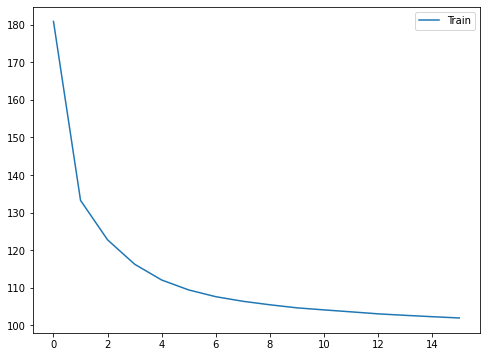

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train')
plt.legend();

### Save or load the model

In [11]:
# Save the trained model
torch.save(model.state_dict(), 'vae_mnist.pth')

# Load a pre-trained model
# model.load_state_dict(torch.load(vae_mnist.pth'), map_location=device))

### Evaluation

In [12]:
model.eval()
test_loss = 0
with torch.no_grad():
    for i, (X_batch, _) in enumerate(test_loader):
        # resize images
        X_batch = X_batch.to(device).view(X_batch.size(0), 784)
        # forward
        X_pred, mu, logvar = model(X_batch)
        test_loss += loss_function(X_pred, X_batch, mu, logvar).item()
        
        # Get first n images from the test set and their approximation via the VAE for display
        if i == 0:
            n = min(X_batch.size(0), 8)
            comparison = torch.cat([X_batch.view(X_batch.size(0), 28, 28)[:n], X_pred.view(X_batch.size(0), 28, 28)[:n]])
            img = comparison.cpu().numpy()

print('Test loss: {}'.format(test_loss / len(test_loader.dataset)))

Test loss: 102.09879692382812


### Display MNIST images

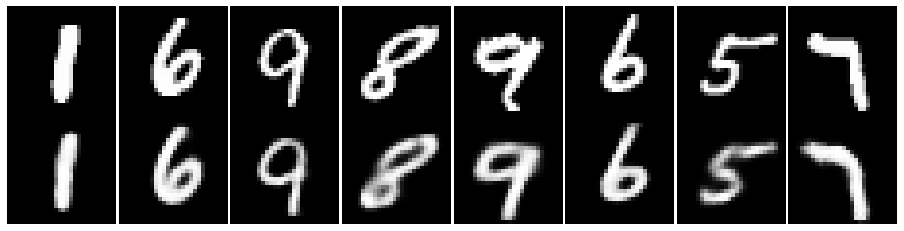

In [13]:
def plot_img(img,n):
    h = img.shape[0] // n
    fig, ax = plt.subplots(h, n, figsize=(16, 2*h))
    for j in range(h):
        for i in range(n):
            ax[j,i].imshow((img[j*n+i]*255.).clip(0,255).astype('uint8'), cmap='gray')
            ax[j,i].axis('off')
    plt.subplots_adjust(hspace=0.0, wspace=0.0)

# Display the images from the test set.
# Top: true image. Bottom: reconstructed (D(E(x))
plot_img(img,n)

### Exploration of the latent space

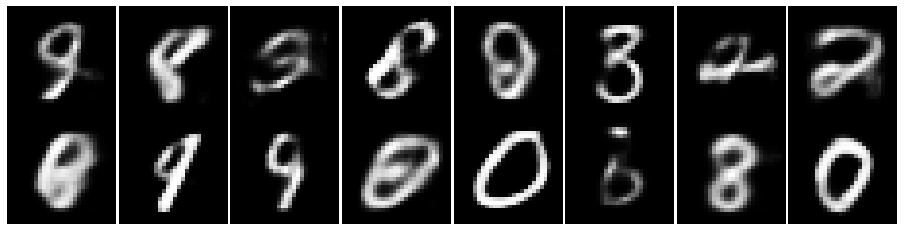

In [14]:
with torch.no_grad():
    z = torch.randn(n*2, 20).to(device)
    sample = model.decode(z).view(-1, 28, 28).cpu().numpy()

# Examples of images samples from the VAE
plot_img(sample,n)

## 2. Application to image denoising
We will now test the network for denoising purpose. Let us start by redefining a data loader for the test set. To begin with, you might process only the first batch of 8 images.

In [15]:
batch_size = 8
latent_dim = 20
test_loader = DataLoader(MNIST('./', train=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
test_iter = test_loader.__iter__()
X_batch, _ = next(test_iter)

We will now investigate a different approach for image denoising: with a gradient descent, we will denoise the images by finding the latent code $z$ which best fits the noisy image, in the least-square sense.

In the following cells, we define some parameters and then apply the denoising technique to the images in the first minibatch.

psnr pour initialisations zero est :  10.893084509081469


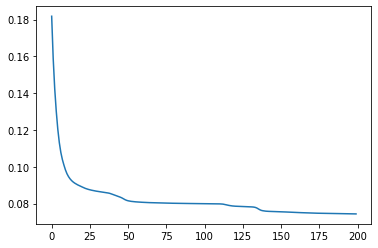

In [56]:
iter = 200 # Number of iterations of the gradient descent
lambda_ = 1e-5 # Lambda parameter for extra regularization
lr = 1e2 # learning rate ()
sigma = 0.25 # std of the noise we will simulate in the images
mse_tot = []
psnr_randn = []

# Get test data, add noise
x = X_batch.to(device).view(batch_size, 28*28)
y = x + sigma*torch.randn_like(x)

# random init
z = torch.randn(batch_size,latent_dim).to(device).requires_grad_()

# Gradient descent      
for e in range(iter):
    x_ = model.decode(z)
    mse = torch.mean((x_.view(-1)-y.view(-1))**2)+lambda_*torch.mean(z**2)
    mse.backward()
    with torch.no_grad():
        z -= lr*z.grad
        z.grad.zero_()
    mse_tot.append(mse.item())
    psnr = 20*np.log10(1/np.sqrt(mse.item()))
    psnr_randn.append(psnr)

print("psnr pour initialisations zero est : ",np.mean(psnr_randn))  
plt.plot(mse_tot)

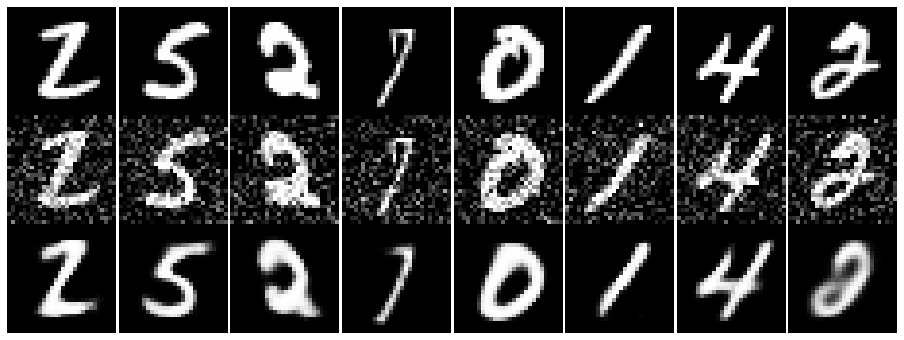

In [57]:
# Display results
xhat = model.decode(z).view(batch_size,28,28).cpu().detach().numpy()
xv = x.view(batch_size,28,28).cpu().numpy()
yv = y.view(batch_size,28,28).cpu().numpy()
img = np.concatenate((xv,yv,xhat))
plot_img(img,batch_size)

We can see that most of the time, the denoising result is ok. But sometimes the algorithm outputs a wrong number. This is because the optimization problem is highly nonconvex! To overcome this, we will try two smarter initializations: one with a vector of zeros, and the other one by encoding the input noisy image.

<font color='red'>Exercise:</font> 
- Implement and compare those two initializations
- compute the average PSNR over the first minibatch or the entire test set, and compare the three methods
- Change the parameters to improve the denoising (lr, lambda, stepsize in the gradient descent)

psnr pour initialisations zero est :  11.274182452415287


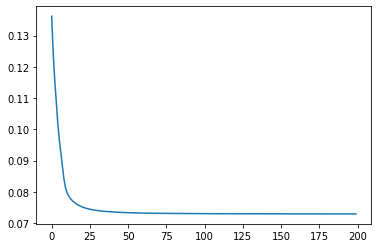

In [58]:
# random init
z = torch.zeros(batch_size,latent_dim).to(device).requires_grad_()
mse_tot = []
psnr_zeros = []

# Gradient descent      
for e in range(iter):
    x_ = model.decode(z)
    mse = torch.mean((x_.view(-1)-y.view(-1))**2)+lambda_*torch.mean(z**2)
    mse.backward()
    with torch.no_grad():
        z -= lr*z.grad
        z.grad.zero_()
    mse_tot.append(mse.item())
    psnr = 20*np.log10(1/np.sqrt(mse.item()))
    psnr_zeros.append(psnr)

print("psnr pour initialisations zero est : ",np.mean(psnr_zeros))     
plt.plot(mse_tot)

psnr pour initialisations zero est :  11.34892780578273


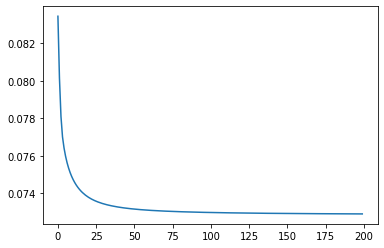

In [59]:
# Initialization with encoded input image
mu, logvar = model.encode(y)
z = model.reparameterize(mu, logvar).detach().to(device).requires_grad_()
mse_tot = []
psnr_eval = []

# Gradient descent
for e in range(iter):
    x_ = model.decode(z)
    mse = torch.mean((x_.view(-1)-y.view(-1))**2)+lambda_*torch.mean(z**2)
    mse.backward()
    with torch.no_grad():
      
        z -= lr*z.grad
        z.grad.zero_()
    mse_tot.append(mse.item())
    psnr = 20*np.log10(1/np.sqrt(mse.item()))
    psnr_eval.append(psnr)

print("psnr pour initialisations zero est : ",np.mean(psnr_eval))     
plt.plot(mse_tot)

On obtient les meilleurs résultats (faible MSE et haut PSNR) avec l'initialisation par encodage de l'image bruitée.

## 3. Application to another inverse problem

<font color='red'>Exercise:</font> apply the above restoration method to an inverse problem. Chose the problem you want: inpainting, deblurring, super-resolution, etc.

In [107]:
batch_size = 8
latent_dim = 20
test_loader = DataLoader(MNIST('./', train=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
test_iter = test_loader.__iter__()
X_batch, _ = next(test_iter)

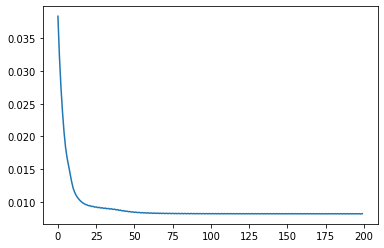

In [124]:
import torch.nn.functional as F
import torchvision

iter = 200 # Number of iterations of the gradient descent
lambda_ = 1e-4 # Lambda parameter for extra regularization
lr = 1e2 # learning rate ()
mse_tot = []

# Get test data, add noise
x = X_batch.to(device).view(batch_size, 28*28)
#weight=np.torch()
#y = F.conv2d(X_batch.view(batch_size, 28, 28), weight=torch.ones(1, 8, 3, 3, device=device)/9, padding=1)
kernel_size = 51
transform = torchvision.transforms.GaussianBlur((5,5), sigma=2)
y = transform(X_batch).to(device)

# random init
z = torch.zeros(batch_size,latent_dim).to(device).requires_grad_()

# Gradient descent      
for e in range(iter):
    x_ = model.decode(z)
    mse = torch.mean((x_.view(-1)-y.view(batch_size*28*28))**2)+lambda_*torch.mean(z**2)
    mse.backward()
    with torch.no_grad():
        z -= lr*z.grad
        z.grad.zero_()
    mse_tot.append(mse.item())
    
plt.plot(mse_tot)

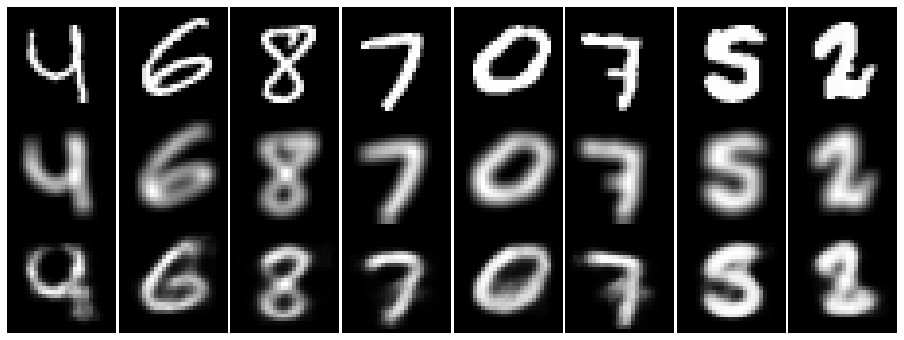

In [125]:
# Display results
xhat = model.decode(z).view(batch_size,28,28).cpu().detach().numpy()
xv = x.view(batch_size,28,28).cpu().numpy()
yv = y.view(batch_size,28,28).cpu().numpy()
img = np.concatenate((xv,yv,xhat))
plot_img(img,batch_size)

## 4. Application to a more complex DNN and/or a more complex dataset
<font color='red'>Exercise:</font> 

- Try to use a more complex VAE, for instance a convolutional VAE. Or alternatively, you can try to modify the dimension of the latent space, but be careful with posterior collapse!
- (Bonus) Consider a more complex dataset such as Fashion MNIST, CIFAR, CelabA. To avoid the training step which can be long and sometimes tricky, you can/should use a pre-trained network. 

In [ ]:
# Your answer, or your results in a separate code
